In [59]:
#generic imports
import csv
from datetime import datetime
import os

#Viz
import matplotlib.pyplot as plt


# Data manipulation
import pandas as pd
import geopandas as gpd
import rasterio as rio
import rasterio.mask
import rasterio.plot
import shapely.geometry

# Numerical stuff
import numpy as np

# Zofe drone HSI data analysis

This notebook serves as an introduction on how to analyse drone datasets from Zofe

In [94]:
# define sets of data path
base_treatment_path = "../../../../data/field_experiments/ZOFE"
base_flight_path = "/media/NASworkspace/95-Patrick/Agroscope_HSI_PROJECT/QGIS"

zofe_data = {"geojson":  os.path.join(base_treatment_path, "plots_zofe.geojson"),
             "20200623": os.path.join(base_flight_path, "Zofe_Analysis/zofe_2306_plotclip.tif"),
             "20200630": os.path.join(base_flight_path, "Zofe_Analysis/zofe_3006_plotclip.tif"),
             "20200707": os.path.join(base_flight_path, "Zofe_Analysis/zofe_0707_plotclip.tif")}
             
demo_data = {"geojson":  os.path.join(base_treatment_path, ""),
             "20200623": os.path.join(base_flight_path, "Demo_Analysis/demo_2306_plotclip.tif"),
             "20200630": os.path.join(base_flight_path, "Demo_Analysis/demo_3006_plotclip.tif"),
             "20200707": os.path.join(base_flight_path, "Demo_Analysis/demo_0707_plotclip.tif")}

def read_treatment(treatment_file_path):
    df = pd.read_csv(zofe_data["20200624"]["treatment_map"], delimiter=";")
    return df

def read_geojson(json_path):
    return gpd.read_file(json_path)

def get_polygons_for_treatment(treatment_id, json_path):
    g = read_geojson(json_path)
    return g[g.Treatment==treatment_id]

def get_rasters_for_treatment(input_tif_path, input_geojson_path, treatment_id, show=False, export=False, export_dir=None):
    """
    Returns a list of np.array of shape (37, ysize, xsize) of type np.float32
    Be careful, the last layer of each np.array, ie the 37th one, is an alpha layer that has value:
    * 0 when mask is not valid
    * 255 when mask is valid
    """
    poly_list = get_polygons_for_treatment(treatment_id, input_geojson_path)
    out_rasters = []
    with rio.open(input_tif_path) as data:
        if show:
            # We may show the overall dataset
            fig, ax = plt.subplots(1, figsize=(16,9))
            ax.set_title(f"ZOFE field")
            rio.plot.show((data, 4), ax=ax, cmap='terrain')
            ax.axis('off')

        # Make copy of metadata
        src_meta = data.meta.copy()
        src_affine = src_meta.get("transform")

        #Re-project into the same coordinate system as the raster data in case it is different
        poly_list.to_crs(crs=data.crs.data)

        # Now for each polygon of the list
        for idx, row in poly_list.iterrows():
            # Clip the main raster to current polygon
            out_img, out_transform = rio.mask.mask(dataset=data, shapes=row.geometry, crop=True)
            out_rasters.append(out_img)
            if show:
                # Now plot
                fig, ax = plt.subplots(1, figsize=(16,9))
                ax.set_title(f"Tile index {idx} for treatment {treatment_id}")
                ax.imshow(np.moveaxis(out_img[[0,10,20],:,:],0,2), cmap='terrain')
                ax.axis('off')

            if export:
                tif_path, filename = os.path.split(input_tif_path)
                base_filename, _ = os.path.splitext(filename)
                if export_dir:
                    os.makedirs(export_dir, exist_ok=True)
                    tif_path = export_dir
                out_tif_path = os.path.join(tif_path,base_filename+f"_treatment_{treatment_id}_index_{idx}"+".tif")
                # Eventually write down the extracted tile as tif
                out_meta = data.meta.copy()
                out_meta.update({"driver": "GTiff",
                                 "height": out_img.shape[1],
                                 "width": out_img.shape[2],
                                 "transform": out_transform,
                                 "crs": data.crs.data})
                with rio.open(out_tif_path, "w", **out_meta) as dest:
                    dest.write(out_img)

    return out_rasters

    id  Treatment                                           geometry
0    1         12  (POLYGON ((8.518473059980714 47.42690291594653...
1    2         11  (POLYGON ((8.518539785730463 47.42690237346076...
2    3         10  (POLYGON ((8.518606782723094 47.42690237346077...
3    4          8  (POLYGON ((8.518740505465475 47.42690115286778...
4    5          9  (POLYGON ((8.518673779715726 47.42690169535355...
5    6          7  (POLYGON ((8.518807502458106 47.42690115286779...
6    7          1  (POLYGON ((8.519208941928126 47.42690006789624...
7    8          3  (POLYGON ((8.519075219185746 47.42690061038201...
8    9          2  (POLYGON ((8.519141944935495 47.42690006789623...
9   10          4  (POLYGON ((8.519008222193113 47.42690045993201...
10  11          5  (POLYGON ((8.518941225200482 47.42690045993201...
11  12          6  (POLYGON ((8.518874499450733 47.42690100241778...
12  13          6  (POLYGON ((8.518472647599545 47.42683994559828...
13  14          5  (POLYGON ((8.51

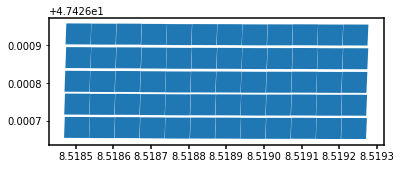

In [36]:
g = read_geojson(zofe_data["geojson"])
print(g)
g.plot()

In [38]:
all_treatment_ids = g.Treatment.unique()
print(all_treatment_ids)
poly_list = get_polygons_for_treatment(1, zofe_data["geojson"])

[12 11 10  8  9  7  1  3  2  4  5  6]


In [39]:
poly_list

,id,Treatment,geometry
6,7,1,(POLYGON ((8.519208941928126 47.42690006789624...
17,18,1,(POLYGON ((8.518807090076937 47.42683818251953...
33,34,1,(POLYGON ((8.519005408134484 47.42677464332935...
38,39,1,(POLYGON ((8.518603264201092 47.42671590609056...
55,56,1,(POLYGON ((8.519071204288389 47.42665229140552...


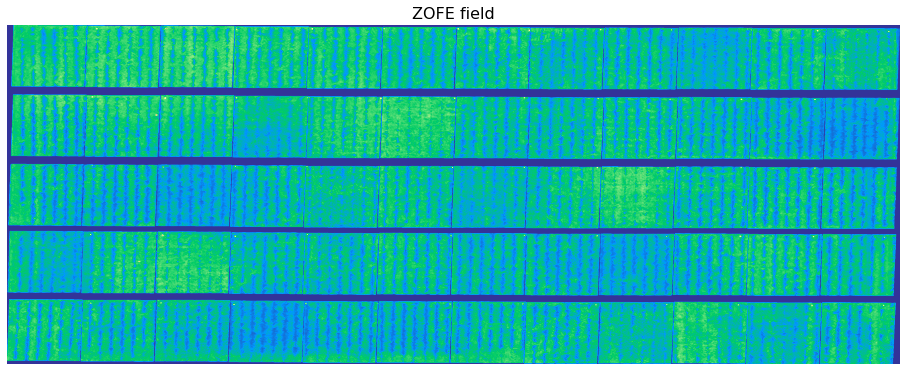

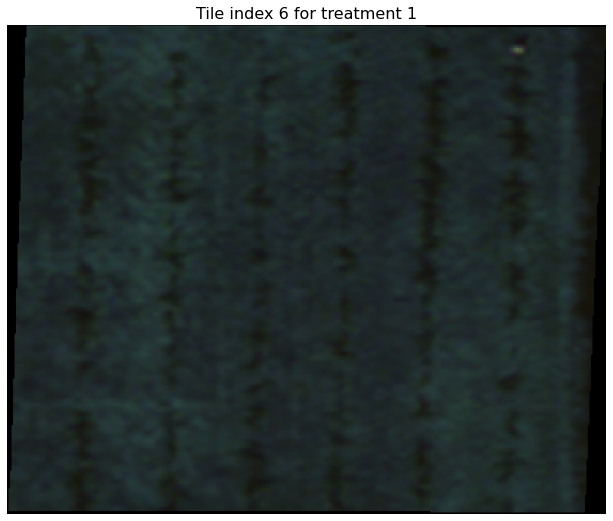

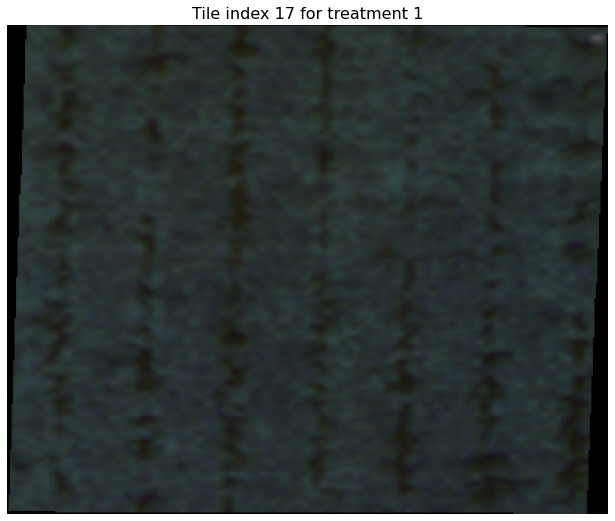

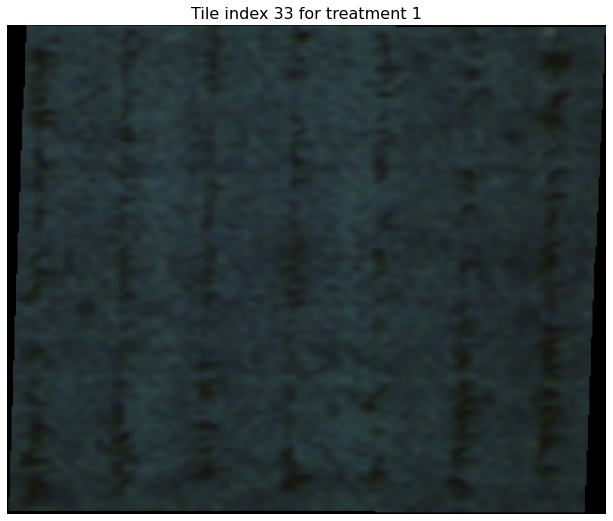

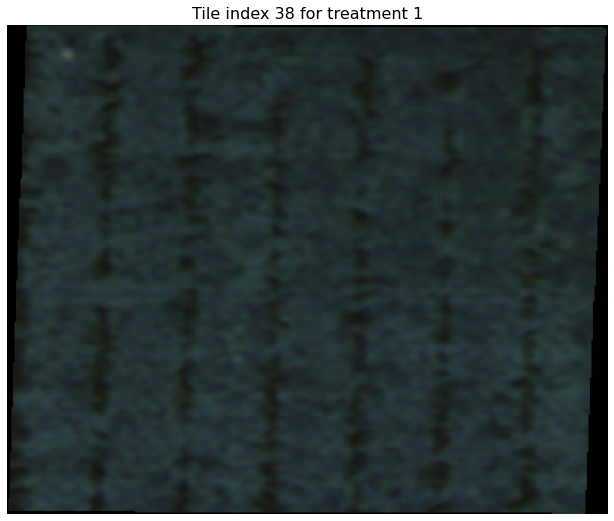

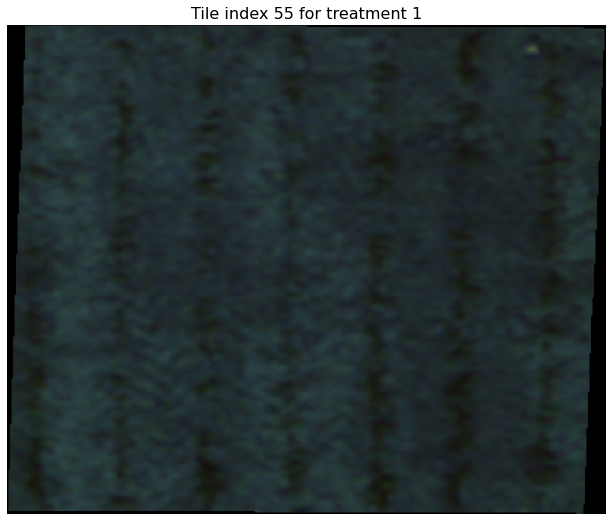

In [95]:
input_tif_path = zofe_data["20200623"]
treatment_id = 1
input_geojson_path = zofe_data["geojson"]
out_rasters = get_rasters_for_treatment(input_tif_path, input_geojson_path, treatment_id, show=True, export=True, export_dir="./test_tif_export")